# Deep Learning for Computer Vision:  COVID-19 Chest X-Ray Classification


* The working process is operated though CRISP-DM process as follwing step
  * 1. Data Understanding
  * 2. Data Preprocessing
  * 3. Modelling
  * 4. Model Evaluation
  * 5. Making a prediction
  * 6. Conclusion

In [ ]:
!pip install tensorflow==2.9.0

In [ ]:
# Library for operating files
import zipfile
import os
import re
import shutil
import math
# Libraries for reading image and visualize data
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
# Libraries for image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Libraries for modelling
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from PIL import Image


In [ ]:

print(tf.__version__)

2.9.0


In [ ]:
# Deleting redundant loading the dataset
# shutil.rmtree('/content/Covid19-dataset', ignore_errors=True)

## 1. Data Understanding

In [ ]:
# Install the Kaggle library
! pip install kaggle

# Make a directory named “.kaggle”
# ! mkdir ~/.kaggle

# Copy the “kaggle.json” into this new directory
! cp kaggle.json ~/.kaggle/

# Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download datasets and unzip
! kaggle datasets download -d pranavraikokte/covid19-image-dataset --unzip

 99% 156M/158M [00:06<00:00, 26.3MB/s]
100% 158M/158M [00:06<00:00, 24.1MB/s]


In [ ]:
# Check number of files in test set
for dirpath, dirnames, filenames in os.walk('/content/Covid19-dataset/test'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/Covid19-dataset/test'.
There are 0 directories and 20 images in '/content/Covid19-dataset/test/Normal'.
There are 0 directories and 20 images in '/content/Covid19-dataset/test/Viral Pneumonia'.
There are 0 directories and 26 images in '/content/Covid19-dataset/test/Covid'.


There are 66 images in test dataset.

In [ ]:
# Check number of files in train set
for dirpath, dirnames, filenames in os.walk('/content/Covid19-dataset/train'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/Covid19-dataset/train'.
There are 0 directories and 70 images in '/content/Covid19-dataset/train/Normal'.
There are 0 directories and 70 images in '/content/Covid19-dataset/train/Viral Pneumonia'.
There are 0 directories and 111 images in '/content/Covid19-dataset/train/Covid'.


There are 251 images in train dataset.

#### Get class names and visualize dataset

In [ ]:
# Get the classnames programmatically
data_dir = pathlib.Path("/content/Covid19-dataset/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Create a list of class_names from the subdirectory
print(class_names)

['Covid' 'Normal' 'Viral Pneumonia']


In [ ]:
# Visualize image
def view_random_image(target_dir, target_class):
  # Setup the target directory
  target_folder = f'{target_dir}/{target_class}'

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Read in the image and plot
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [ ]:
# View a random image from the dataset

# target_dir = "/content/Covid19-dataset/train"
# figsize=(10, 7)
# plt.figure(figsize=figsize)

# plt.subplot(2, 3, 1)
# crack_img = view_random_image(target_dir,
#                               target_class="Covid")
# plt.subplot(2, 3, 2)
# no_crack_img = view_random_image(target_dir,
#                               target_class="Normal")

# plt.subplot(2, 3, 3)
# no_crack_img = view_random_image(target_dir,
#                               target_class="Viral Pneumonia")

## 2. Preprocessing the data


In [ ]:
train_dir = '/content/Covid19-dataset/train'
filepaths = []
labels = []

folds = os.listdir(train_dir)
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
train_df

,filepaths,labels
0,/content/Covid19-dataset/train/Normal/084.jpeg,Normal
1,/content/Covid19-dataset/train/Normal/079.jpeg,Normal
2,/content/Covid19-dataset/train/Normal/058.jpeg,Normal
3,/content/Covid19-dataset/train/Normal/02.jpeg,Normal
4,/content/Covid19-dataset/train/Normal/096.jpeg,Normal
...,...,...
246,/content/Covid19-dataset/train/Viral Pneumonia...,Viral Pneumonia
247,/content/Covid19-dataset/train/Viral Pneumonia...,Viral Pneumonia
248,/content/Covid19-dataset/train/Viral Pneumonia...,Viral Pneumonia
249,/content/Covid19-dataset/train/Viral Pneumonia...,Viral Pneumonia


In [ ]:
test_dir = '/content/Covid19-dataset/test'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
# valid and test dataframe
valid_df, test_df = train_test_split(test_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 251 validated image filenames belonging to 3 classes.
Found 39 validated image filenames belonging to 3 classes.
Found 27 validated image filenames belonging to 3 classes.


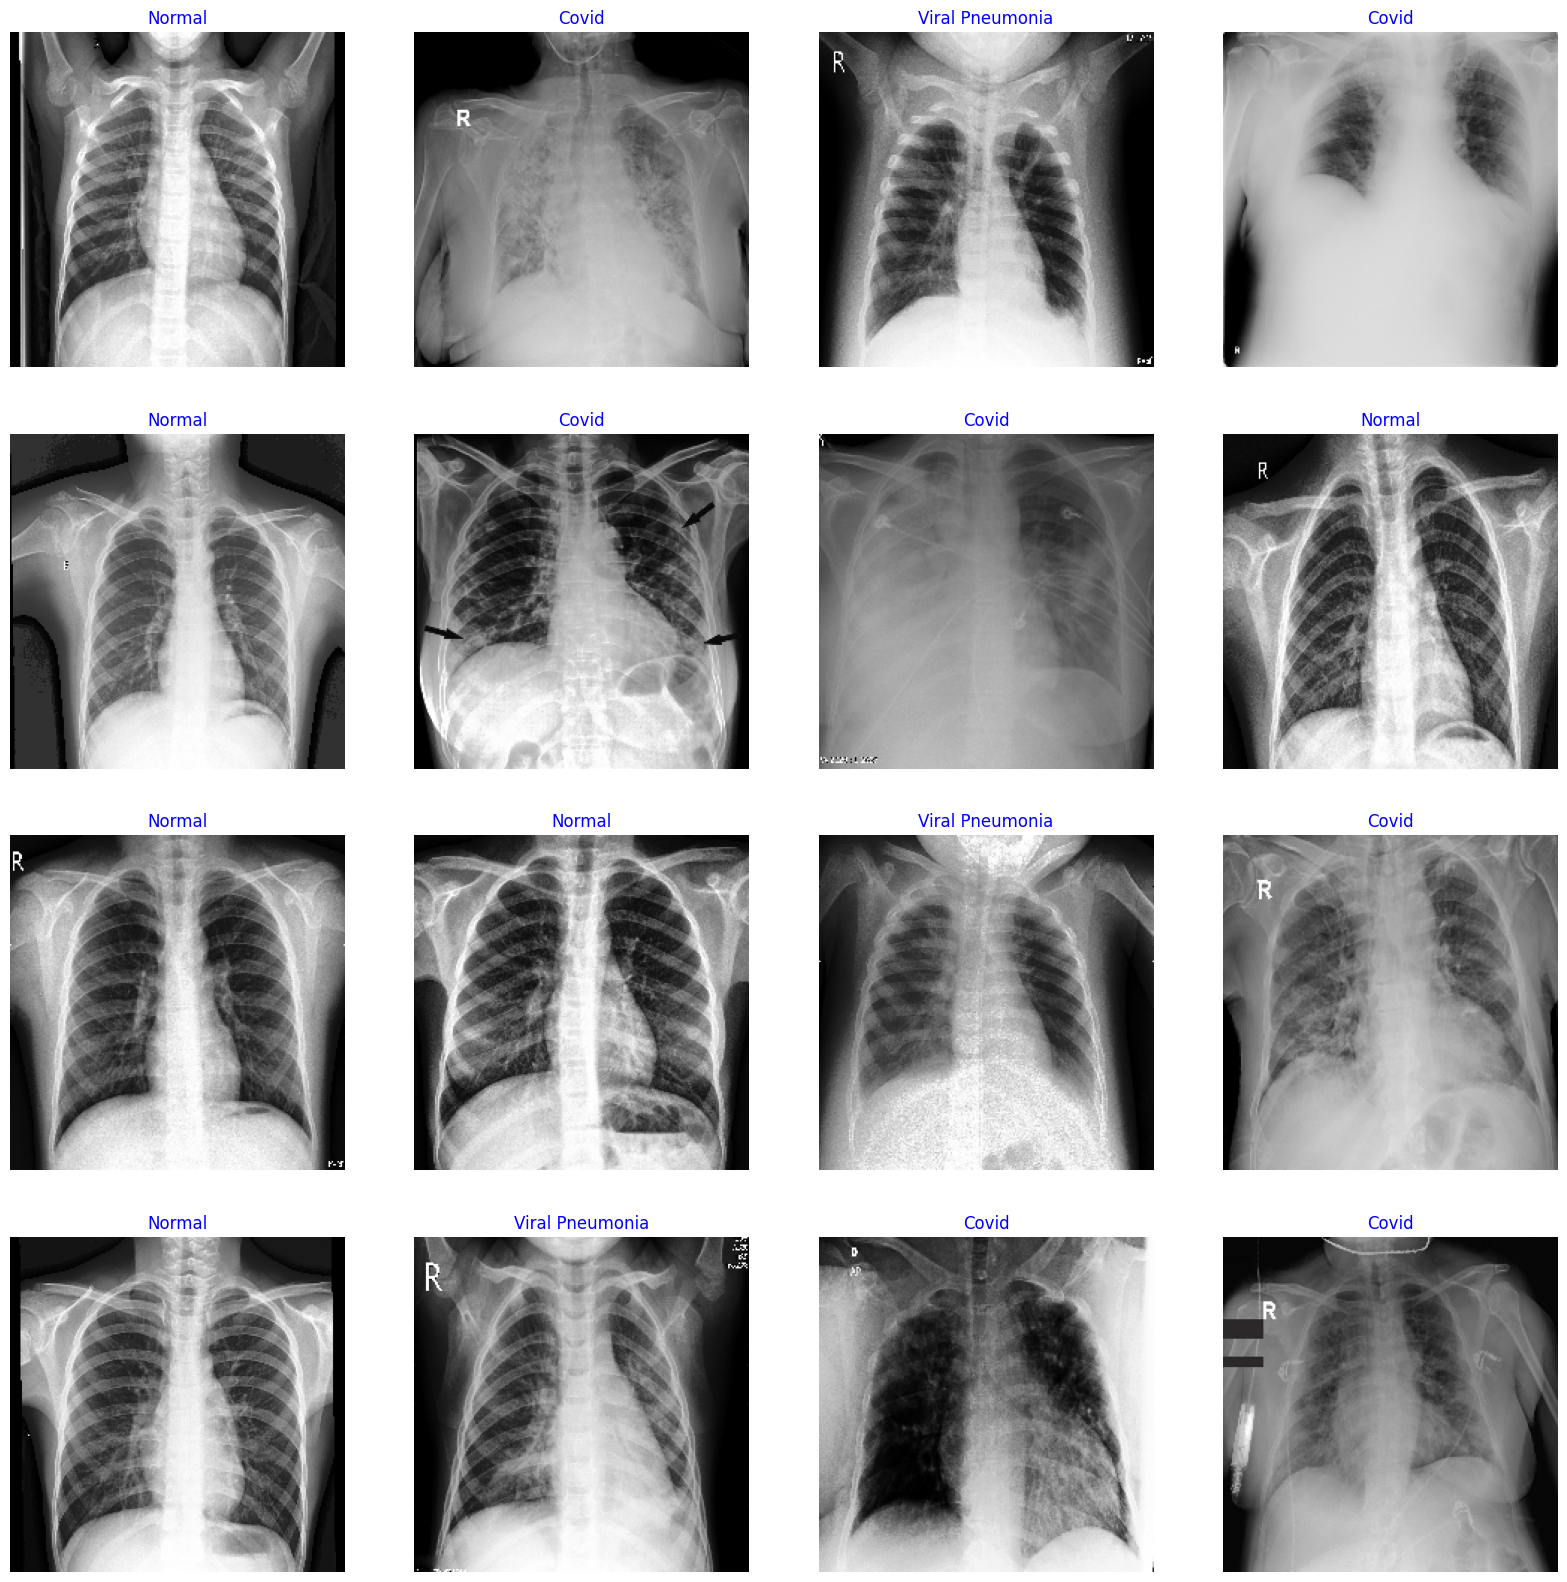

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
# Create plot function to visualize loss curve
def plot_loss_curve(history):
  """
  Returns separated loss curve for training and validation metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 4,383,398
Trainable params: 331,267
Non-trainable params: 4,052,131
________________________________________

In [ ]:
batch_size = 20   # set batch size for training
epochs =  20  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/20
16/16 [==============================] - 18s 582ms/step - loss: 8.4291 - accuracy: 0.6375 - val_loss: 11.4961 - val_accuracy: 0.3846
Epoch 2/20
16/16 [==============================] - 7s 416ms/step - loss: 7.3951 - accuracy: 0.8765 - val_loss: 9.1555 - val_accuracy: 0.5128
Epoch 3/20
16/16 [==============================] - 7s 438ms/step - loss: 6.9777 - accuracy: 0.9323 - val_loss: 7.6524 - val_accuracy: 0.6410
Epoch 4/20
16/16 [==============================] - 6s 358ms/step - loss: 6.6830 - accuracy: 0.9124 - val_loss: 7.0446 - val_accuracy: 0.7949
Epoch 5/20
16/16 [==============================] - 6s 353ms/step - loss: 6.2902 - accuracy: 0.9641 - val_loss: 6.5880 - val_accuracy: 0.8462
Epoch 6/20
16/16 [==============================] - 5s 325ms/step - loss: 6.0414 - accuracy: 0.9681 - val_loss: 6.1422 - val_accuracy: 0.8718
Epoch 7/20
16/16 [==============================] - 6s 410ms/step - loss: 5.7867 - accuracy: 0.9801 - val_loss: 5.8393 - val_accuracy: 0.8718
Epoc

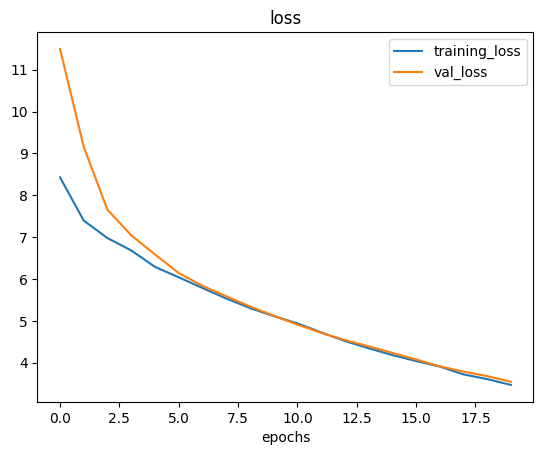

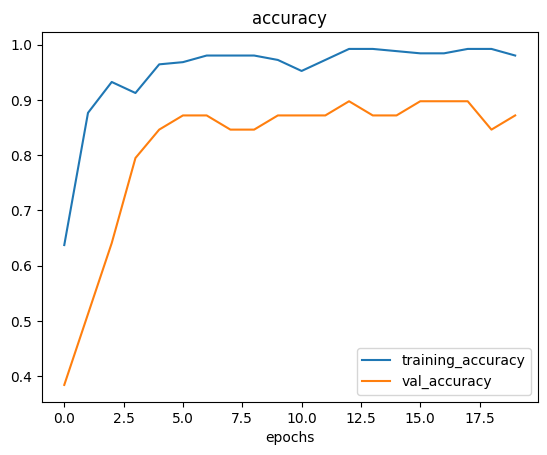

In [ ]:
plot_loss_curve(history)

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False
model2 = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model2.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 4,383,398
Trainable params: 331,267
Non-trainable params: 4,052,131
______________________________________

In [ ]:
batch_size = 20   # set batch size for training
epochs =  20  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/20
16/16 [==============================] - 6s 350ms/step - loss: 3.3271 - accuracy: 0.9960 - val_loss: 3.4050 - val_accuracy: 0.8974
Epoch 2/20
16/16 [==============================] - 5s 318ms/step - loss: 3.2234 - accuracy: 0.9920 - val_loss: 3.2950 - val_accuracy: 0.8974
Epoch 3/20
16/16 [==============================] - 6s 377ms/step - loss: 3.0768 - accuracy: 0.9920 - val_loss: 3.1938 - val_accuracy: 0.8718
Epoch 4/20
16/16 [==============================] - 5s 312ms/step - loss: 3.0097 - accuracy: 0.9761 - val_loss: 3.0582 - val_accuracy: 0.9487
Epoch 5/20
16/16 [==============================] - 6s 397ms/step - loss: 2.8642 - accuracy: 0.9920 - val_loss: 2.9680 - val_accuracy: 0.9231
Epoch 6/20
16/16 [==============================] - 5s 310ms/step - loss: 2.7608 - accuracy: 1.0000 - val_loss: 2.8513 - val_accuracy: 0.9231
Epoch 7/20
16/16 [==============================] - 6s 393ms/step - loss: 2.6466 - accuracy: 0.9960 - val_loss: 2.7378 - val_accuracy: 0.9231
Epoch 

In [ ]:
batch_size = 20   # set batch size for training
epochs =  20  # number of all epochs in training

history2 = model2.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/20
16/16 [==============================] - 8s 482ms/step - loss: 6.8606 - accuracy: 0.9084 - val_loss: 6.9786 - val_accuracy: 0.7949
Epoch 2/20
16/16 [==============================] - 5s 315ms/step - loss: 5.9212 - accuracy: 0.9522 - val_loss: 5.9163 - val_accuracy: 0.8718
Epoch 3/20
16/16 [==============================] - 5s 323ms/step - loss: 5.0461 - accuracy: 0.9641 - val_loss: 4.9919 - val_accuracy: 0.8462
Epoch 4/20
16/16 [==============================] - 6s 396ms/step - loss: 4.2494 - accuracy: 0.9880 - val_loss: 4.0966 - val_accuracy: 0.8974
Epoch 5/20
16/16 [==============================] - 7s 415ms/step - loss: 3.5757 - accuracy: 0.9920 - val_loss: 3.4473 - val_accuracy: 0.9231
Epoch 6/20
16/16 [==============================] - 5s 302ms/step - loss: 3.0229 - accuracy: 0.9960 - val_loss: 2.8426 - val_accuracy: 1.0000
Epoch 7/20
16/16 [==============================] - 5s 323ms/step - loss: 2.5327 - accuracy: 0.9880 - val_loss: 2.4310 - val_accuracy: 1.0000
Epoch 

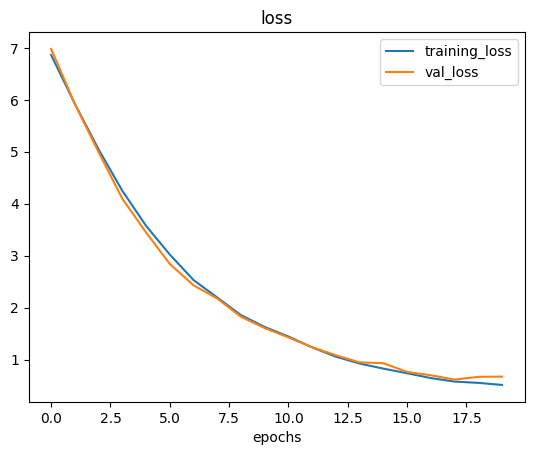

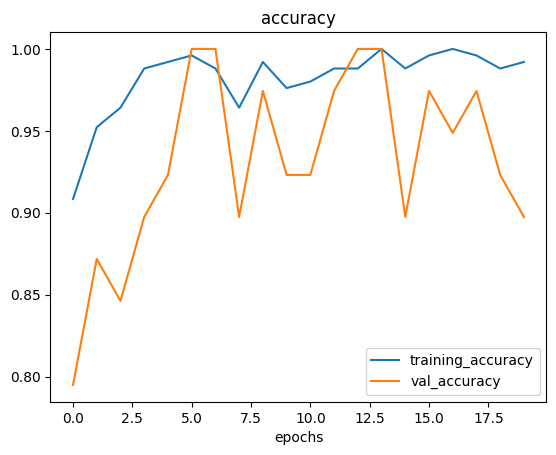

In [ ]:
plot_loss_curve(history2)

### Augmentation

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
                            rotation_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            horizontal_flip=True)
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 251 validated image filenames belonging to 3 classes.
Found 39 validated image filenames belonging to 3 classes.
Found 27 validated image filenames belonging to 3 classes.


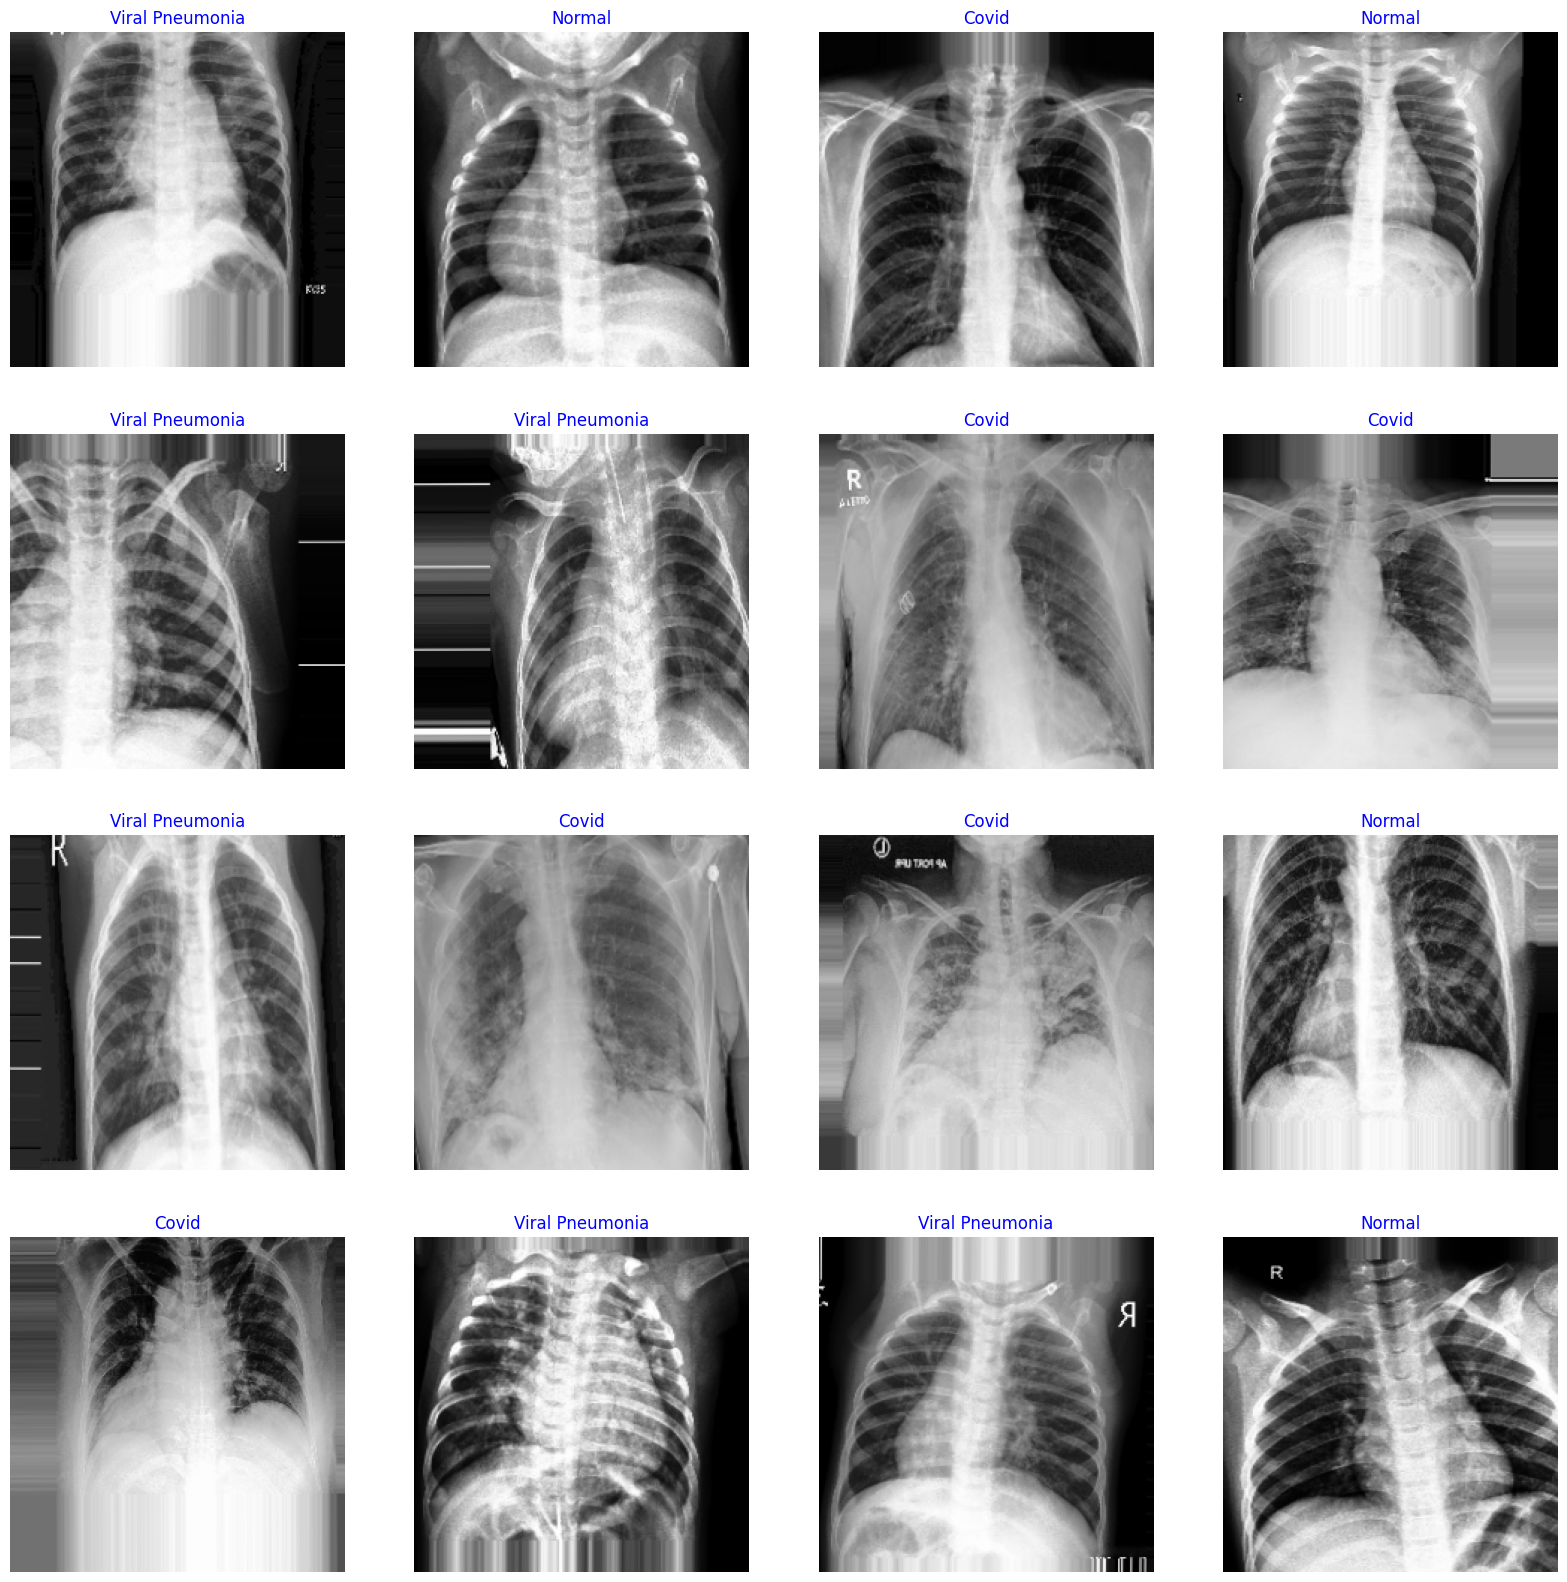

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]/255.      # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False
model3 = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model3.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization_3 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 4,383,398
Trainable params: 331,267
Non-trainable params: 4,052,131
______________________________________

In [ ]:
batch_size = 20   # set batch size for training
epochs =  20  # number of all epochs in training

history = model3.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/20
16/16 [==============================] - 17s 609ms/step - loss: 8.4904 - accuracy: 0.6255 - val_loss: 8.5244 - val_accuracy: 0.8462
Epoch 2/20
16/16 [==============================] - 9s 576ms/step - loss: 7.3729 - accuracy: 0.8406 - val_loss: 7.4070 - val_accuracy: 0.8205
Epoch 3/20
16/16 [==============================] - 7s 450ms/step - loss: 6.6420 - accuracy: 0.8327 - val_loss: 6.5334 - val_accuracy: 0.9487
Epoch 4/20
16/16 [==============================] - 9s 573ms/step - loss: 6.0071 - accuracy: 0.8685 - val_loss: 5.9588 - val_accuracy: 0.8718
Epoch 5/20
16/16 [==============================] - 8s 492ms/step - loss: 5.3714 - accuracy: 0.8964 - val_loss: 5.3362 - val_accuracy: 0.8462
Epoch 6/20
16/16 [==============================] - 9s 567ms/step - loss: 4.8505 - accuracy: 0.9163 - val_loss: 4.5610 - val_accuracy: 0.9487
Epoch 7/20
16/16 [==============================] - 8s 477ms/step - loss: 4.3564 - accuracy: 0.9163 - val_loss: 4.1196 - val_accuracy: 0.8974
Epoch

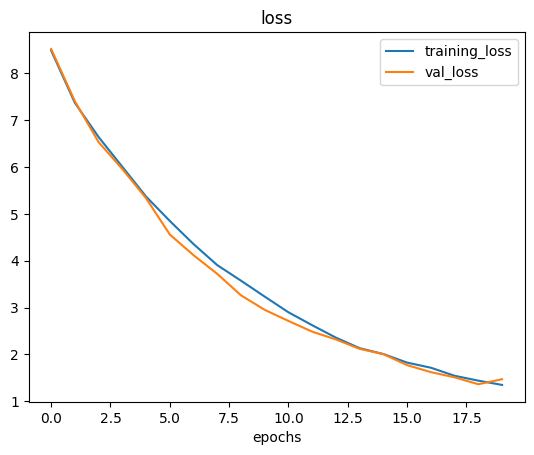

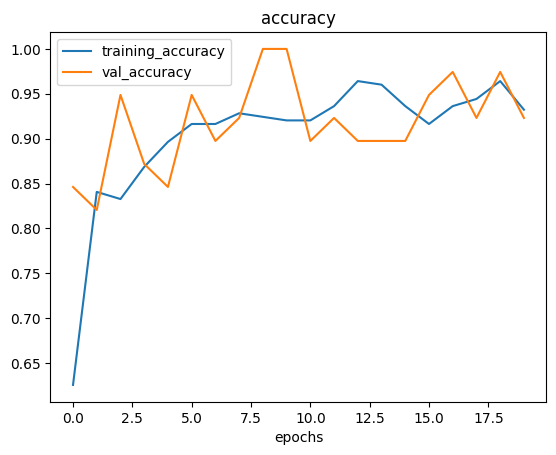

In [ ]:
plot_loss_curve(history)

In [ ]:
from tensorflow.keras.callbacks import Callback
class myCallback(Callback):
    def on_epoch_end(self,epoch,logs={}):
        if logs.get('val_accuracy')>=0.98:
            print("\nReached More than 98% accuraccy")
            self.model.stop_training=True
callback=myCallback()

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False
model4 = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model4.compile(Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization_4 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 256)               327936    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 4,383,398
Trainable params: 331,267
Non-trainable params: 4,052,131
______________________________________

In [ ]:
history3 = model4.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False, callbacks=callback)

Epoch 1/20
16/16 [==============================] - 17s 570ms/step - loss: 9.1867 - accuracy: 0.3904 - val_loss: 9.4646 - val_accuracy: 0.4872
Epoch 2/20
16/16 [==============================] - 9s 562ms/step - loss: 8.6788 - accuracy: 0.5100 - val_loss: 8.8967 - val_accuracy: 0.6154
Epoch 3/20
16/16 [==============================] - 7s 461ms/step - loss: 8.3608 - accuracy: 0.6534 - val_loss: 8.5165 - val_accuracy: 0.6923
Epoch 4/20
16/16 [==============================] - 7s 440ms/step - loss: 8.1770 - accuracy: 0.6454 - val_loss: 8.1943 - val_accuracy: 0.7436
Epoch 5/20
16/16 [==============================] - 9s 566ms/step - loss: 7.9761 - accuracy: 0.7371 - val_loss: 7.9585 - val_accuracy: 0.7436
Epoch 6/20
16/16 [==============================] - 7s 452ms/step - loss: 7.7983 - accuracy: 0.8048 - val_loss: 7.7750 - val_accuracy: 0.7692
Epoch 7/20
16/16 [==============================] - 9s 568ms/step - loss: 7.7627 - accuracy: 0.7689 - val_loss: 7.6012 - val_accuracy: 0.7436
Epoch

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer


# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False
model6 = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model6.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model6.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization_7 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_14 (Dense)            (None, 256)               327936    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 3)                 771       
                                                                 
Total params: 4,383,398
Trainable params: 331,267
Non-trainable params: 4,052,131
______________________________________

In [ ]:
batch_size = 20   # set batch size for training
epochs =  100  # number of all epochs in training
history5 = model6.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False, callbacks=callback)

Epoch 1/100
16/16 [==============================] - 16s 663ms/step - loss: 8.3498 - accuracy: 0.6534 - val_loss: 8.3580 - val_accuracy: 0.7692
Epoch 2/100
16/16 [==============================] - 8s 512ms/step - loss: 7.2635 - accuracy: 0.8367 - val_loss: 7.2147 - val_accuracy: 0.7949
Epoch 3/100
16/16 [==============================] - 7s 439ms/step - loss: 6.4690 - accuracy: 0.8805 - val_loss: 6.8521 - val_accuracy: 0.7692
Epoch 4/100
16/16 [==============================] - 9s 556ms/step - loss: 5.7798 - accuracy: 0.8566 - val_loss: 5.6280 - val_accuracy: 0.8462
Epoch 5/100
16/16 [==============================] - 7s 447ms/step - loss: 5.1073 - accuracy: 0.9004 - val_loss: 4.9143 - val_accuracy: 0.8205
Epoch 6/100
16/16 [==============================] - 9s 566ms/step - loss: 4.5568 - accuracy: 0.9084 - val_loss: 4.3988 - val_accuracy: 0.8205
Epoch 7/100
16/16 [==============================] - 7s 463ms/step - loss: 4.1409 - accuracy: 0.8725 - val_loss: 3.8577 - val_accuracy: 0.923

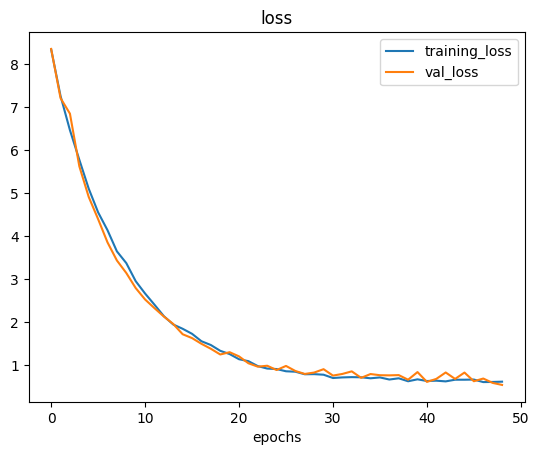

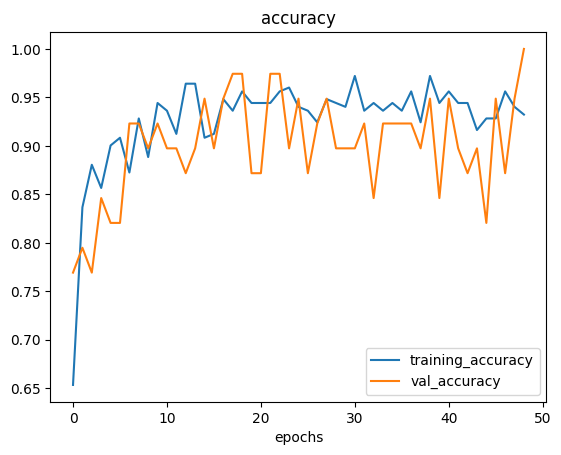

In [ ]:
plot_loss_curve(history5)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model6.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model6.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model6.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 0s 250ms/step - loss: 0.5203 - accuracy: 1.0000
Train Loss:  0.48512816429138184
Train Accuracy:  1.0
--------------------
Validation Loss:  0.49046364426612854
Validation Accuracy:  1.0
--------------------
Test Loss:  0.5202869176864624
Test Accuracy:  1.0


In [ ]:
preds = model6.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

<ipython-input-63-58b71a80fd50>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model6.predict_generator(test_gen)


In [ ]:
y_pred

array([2, 2, 0, 0, 2, 2, 1, 2, 2, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 1, 2, 1,
       1, 2, 0, 0, 1])

In [ ]:
# test_gen.classes

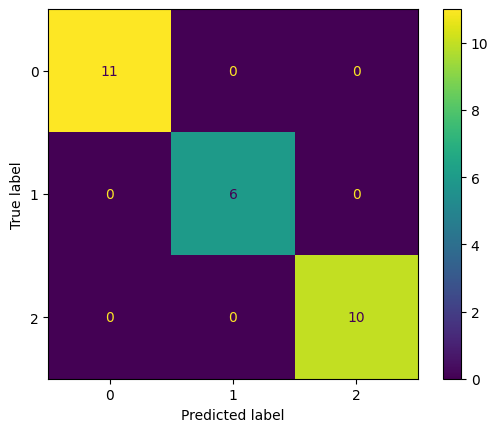

In [ ]:
cm = confusion_matrix(test_gen.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm
                            )
disp.plot()
plt.show()

In [ ]:
def summary_model(model_no):
  # Predict classes
  test_steps_per_epoch = np.math.ceil(test_gen.samples / test_gen.batch_size)

  predictions = model_no.predict_generator(test_gen, steps=test_steps_per_epoch)

  # Get most likely class
  predicted_classes = np.argmax(predictions, axis=1)
  # print(predicted_classes)

  # Get ground-truth classes and class-labels
  true_classes = test_gen.classes
  class_labels = list(test_gen.class_indices.keys())
  # print(class_labels)
  print("0: 'Covid', 1: 'Normal', 2: 'Viral Pneumonia'")

  # Concusion matrix
  print("confusion matrix")
  print(confusion_matrix(true_classes, predicted_classes))

  # Use scikit-learn to get statistics
  report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
  print(report)

In [ ]:
summary_model(model6)

<ipython-input-66-bf4f9a0b2400>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_no.predict_generator(test_gen, steps=test_steps_per_epoch)


0: 'Covid', 1: 'Normal', 2: 'Viral Pneumonia'
confusion matrix
[[11  0  0]
 [ 0  6  0]
 [ 0  0 10]]
                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        11
         Normal       1.00      1.00      1.00         6
Viral Pneumonia       1.00      1.00      1.00        10

       accuracy                           1.00        27
      macro avg       1.00      1.00      1.00        27
   weighted avg       1.00      1.00      1.00        27



In [ ]:
#Save the model
model6.save('bestmodel.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/bestmodel.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/content/Covid19-dataset/test/Covid/0102.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}, {np.max(score.numpy()):.2f}")

1/1 [==============================] - 0s 79ms/step
Covid, 0.58
